# I. Intro to LightGBM


In [1]:
import gc
import os
import math
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import roc_auc_score, roc_curve
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import lightgbm as lgb
import time
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn.metrics import mean_absolute_error
import seaborn as sns

## Quick Data Treatment

In [2]:
df = pd.read_csv('data/titanic.csv')

In [4]:
df = df.drop(columns = ["Name"])

In [9]:
df = df.drop(columns = ["Single"])

In [5]:
df.Sex = df.Sex.replace("male", 1)
df.Sex = df.Sex.replace("female", 2)

In [6]:
df.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'Siblings/Spouses Aboard',
       'Parents/Children Aboard', 'Fare'],
      dtype='object')

In [7]:
df["family_size"] = df["Siblings/Spouses Aboard"] + df["Parents/Children Aboard"]

In [10]:
df["single"] = (df["family_size"] == 0) * 1.0

In [11]:
df["elder"] =(df["Age"] > 60) * 1.0

In [12]:
df.head()

,Survived,Pclass,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare,family_size,single,elder
0,0,3,1,22.0,1,0,7.2500,1,0.0,0.0
1,1,1,2,38.0,1,0,71.2833,1,0.0,0.0
2,1,3,2,26.0,0,0,7.9250,0,1.0,0.0
3,1,1,2,35.0,1,0,53.1000,1,0.0,0.0
4,0,3,1,35.0,0,0,8.0500,0,1.0,0.0


In [14]:
y = df.Survived

In [15]:
X = df.copy()
X = X.drop(columns=["Survived"])

Normalize the data X (optional)

In [16]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = pd.DataFrame(scaler.transform(X), columns=X.columns)

In [17]:
X_scaled_train, X_scaled_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=20)

This function is to show which featuree is important

In [18]:
def plot_feature_importance(feature_importance,title):
    fe = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
        by="importance", ascending=False)
    fe['feature'] = fe.index
    plt.figure(figsize=(16, 12))
    sns.barplot(x="importance", y="feature", data=fe)
    plt.xticks([])
    plt.title(title)
    return

In [19]:
def train_lgb(X_train, X_valid, y_train, y_valid, params=None):

    model = lgb.LGBMClassifier(**params)
    model.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric=['auc', 'binary_logloss'],
            verbose=1, early_stopping_rounds=50)

    y_pred_train = model.predict(X_train)
    y_pred_valid = model.predict(X_valid)

    importance = pd.DataFrame()
    importance["feature"] = X.columns
    importance["importance"] = model.feature_importances_
    return y_pred_train, y_pred_valid, importance

In [20]:
params = {
          'n_estimators': 5000,  # Number of trees
          'num_leaves': 6,  # max number of leaves in tree
          'min_data_in_leaf': 2,
          'max_depth': -1,
          'learning_rate': 0.02,
          "boosting": "gbdt",
          "bagging_freq": 10,
          'num_threads': 8,
          "bagging_fraction": 0.7,
          "bagging_seed": 11,
          "metric": 'binary_logloss',
         }

In [31]:
y_pred_train, y_pred_test, feature_importance = train_lgb(X_scaled_train, X_scaled_test, y_train, y_test, params=params)

[1]	training's auc: 0.859197	training's binary_logloss: 0.654729	valid_1's auc: 0.82544	valid_1's binary_logloss: 0.67065
Training until validation scores don't improve for 50 rounds
[2]	training's auc: 0.859197	training's binary_logloss: 0.646092	valid_1's auc: 0.82544	valid_1's binary_logloss: 0.662802
[3]	training's auc: 0.859197	training's binary_logloss: 0.637837	valid_1's auc: 0.82544	valid_1's binary_logloss: 0.655313
[4]	training's auc: 0.861157	training's binary_logloss: 0.629898	valid_1's auc: 0.824658	valid_1's binary_logloss: 0.648208
[5]	training's auc: 0.861157	training's binary_logloss: 0.622334	valid_1's auc: 0.824658	valid_1's binary_logloss: 0.64137
[6]	training's auc: 0.864063	training's binary_logloss: 0.615047	valid_1's auc: 0.829093	valid_1's binary_logloss: 0.634877
[7]	training's auc: 0.861157	training's binary_logloss: 0.608095	valid_1's auc: 0.824658	valid_1's binary_logloss: 0.628614
[8]	training's auc: 0.864388	training's binary_logloss: 0.601346	valid_1's a

[85]	training's auc: 0.89913	training's binary_logloss: 0.401103	valid_1's auc: 0.854142	valid_1's binary_logloss: 0.449714
[86]	training's auc: 0.899594	training's binary_logloss: 0.400154	valid_1's auc: 0.855055	valid_1's binary_logloss: 0.448699
[87]	training's auc: 0.899603	training's binary_logloss: 0.399209	valid_1's auc: 0.855186	valid_1's binary_logloss: 0.447923
[88]	training's auc: 0.899772	training's binary_logloss: 0.398325	valid_1's auc: 0.854664	valid_1's binary_logloss: 0.447169
[89]	training's auc: 0.899763	training's binary_logloss: 0.397467	valid_1's auc: 0.854142	valid_1's binary_logloss: 0.446263
[90]	training's auc: 0.899831	training's binary_logloss: 0.396611	valid_1's auc: 0.854273	valid_1's binary_logloss: 0.445588
[91]	training's auc: 0.900249	training's binary_logloss: 0.395983	valid_1's auc: 0.853294	valid_1's binary_logloss: 0.444989
[92]	training's auc: 0.899962	training's binary_logloss: 0.395381	valid_1's auc: 0.853294	valid_1's binary_logloss: 0.444419
[

[182]	training's auc: 0.914942	training's binary_logloss: 0.351855	valid_1's auc: 0.862361	valid_1's binary_logloss: 0.429966
[183]	training's auc: 0.915161	training's binary_logloss: 0.351527	valid_1's auc: 0.862231	valid_1's binary_logloss: 0.430002
[184]	training's auc: 0.915389	training's binary_logloss: 0.351158	valid_1's auc: 0.8621	valid_1's binary_logloss: 0.429898
[185]	training's auc: 0.915558	training's binary_logloss: 0.350849	valid_1's auc: 0.862231	valid_1's binary_logloss: 0.42995
[186]	training's auc: 0.915757	training's binary_logloss: 0.350366	valid_1's auc: 0.862296	valid_1's binary_logloss: 0.429624
[187]	training's auc: 0.915808	training's binary_logloss: 0.350076	valid_1's auc: 0.860861	valid_1's binary_logloss: 0.42969
[188]	training's auc: 0.915888	training's binary_logloss: 0.349838	valid_1's auc: 0.860861	valid_1's binary_logloss: 0.429601
[189]	training's auc: 0.915998	training's binary_logloss: 0.349387	valid_1's auc: 0.860992	valid_1's binary_logloss: 0.429

Print accuracy of Train and Test

In [28]:
def calc_accuracy(y_pred, y):
    return sum(y_pred == y)/len(y)

In [32]:
print(calc_accuracy(y_pred_train, y_train))
print(calc_accuracy(y_pred_test, y_test))

0.8631875881523272
0.8258426966292135


Plot the feature importance

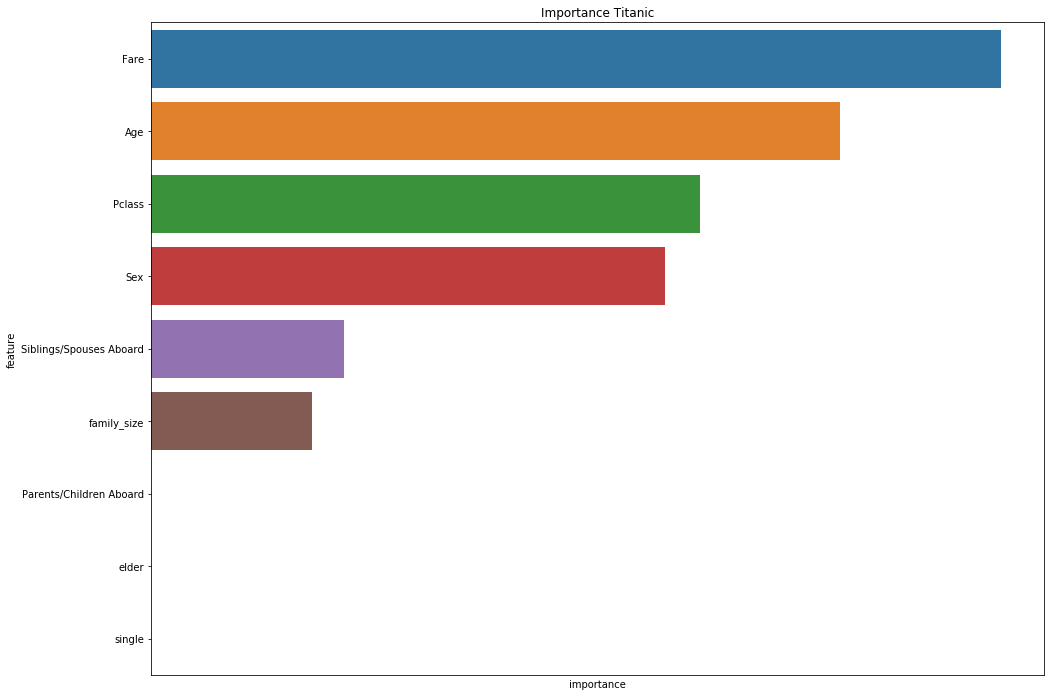

In [33]:
plot_feature_importance(feature_importance, title = 'Importance Titanic')

**Exercise:** Retrain without rescale X to see anything different

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

In [35]:
y_pred_train, y_pred_test, feature_importance = train_lgb(X_train, X_test, y_train, y_test, params=params)

[1]	training's auc: 0.859197	training's binary_logloss: 0.654729	valid_1's auc: 0.82544	valid_1's binary_logloss: 0.67065
Training until validation scores don't improve for 50 rounds
[2]	training's auc: 0.859197	training's binary_logloss: 0.646092	valid_1's auc: 0.82544	valid_1's binary_logloss: 0.662802
[3]	training's auc: 0.859197	training's binary_logloss: 0.637837	valid_1's auc: 0.82544	valid_1's binary_logloss: 0.655313
[4]	training's auc: 0.861157	training's binary_logloss: 0.629898	valid_1's auc: 0.824658	valid_1's binary_logloss: 0.648208
[5]	training's auc: 0.861157	training's binary_logloss: 0.622334	valid_1's auc: 0.824658	valid_1's binary_logloss: 0.64137
[6]	training's auc: 0.864063	training's binary_logloss: 0.615047	valid_1's auc: 0.829093	valid_1's binary_logloss: 0.634877
[7]	training's auc: 0.861157	training's binary_logloss: 0.608095	valid_1's auc: 0.824658	valid_1's binary_logloss: 0.628614
[8]	training's auc: 0.864388	training's binary_logloss: 0.601346	valid_1's a

[80]	training's auc: 0.89826	training's binary_logloss: 0.406423	valid_1's auc: 0.854925	valid_1's binary_logloss: 0.454814
[81]	training's auc: 0.898547	training's binary_logloss: 0.405294	valid_1's auc: 0.855055	valid_1's binary_logloss: 0.453583
[82]	training's auc: 0.898876	training's binary_logloss: 0.404207	valid_1's auc: 0.854925	valid_1's binary_logloss: 0.452401
[83]	training's auc: 0.899037	training's binary_logloss: 0.403126	valid_1's auc: 0.854664	valid_1's binary_logloss: 0.451468
[84]	training's auc: 0.899189	training's binary_logloss: 0.402113	valid_1's auc: 0.854534	valid_1's binary_logloss: 0.450565
[85]	training's auc: 0.89913	training's binary_logloss: 0.401103	valid_1's auc: 0.854142	valid_1's binary_logloss: 0.449714
[86]	training's auc: 0.899594	training's binary_logloss: 0.400154	valid_1's auc: 0.855055	valid_1's binary_logloss: 0.448699
[87]	training's auc: 0.899603	training's binary_logloss: 0.399209	valid_1's auc: 0.855186	valid_1's binary_logloss: 0.447923
[8

[159]	training's auc: 0.910882	training's binary_logloss: 0.360285	valid_1's auc: 0.863014	valid_1's binary_logloss: 0.43261
[160]	training's auc: 0.911009	training's binary_logloss: 0.35996	valid_1's auc: 0.863536	valid_1's binary_logloss: 0.432862
[161]	training's auc: 0.911292	training's binary_logloss: 0.359445	valid_1's auc: 0.863666	valid_1's binary_logloss: 0.43228
[162]	training's auc: 0.911469	training's binary_logloss: 0.358953	valid_1's auc: 0.864057	valid_1's binary_logloss: 0.431731
[163]	training's auc: 0.911537	training's binary_logloss: 0.358483	valid_1's auc: 0.864188	valid_1's binary_logloss: 0.431212
[164]	training's auc: 0.911697	training's binary_logloss: 0.358034	valid_1's auc: 0.864449	valid_1's binary_logloss: 0.43072
[165]	training's auc: 0.91179	training's binary_logloss: 0.357605	valid_1's auc: 0.864579	valid_1's binary_logloss: 0.430254
[166]	training's auc: 0.911985	training's binary_logloss: 0.357194	valid_1's auc: 0.86471	valid_1's binary_logloss: 0.42981

In [36]:
print(calc_accuracy(y_pred_train, y_train))
print(calc_accuracy(y_pred_test, y_test))

0.8631875881523272
0.8258426966292135


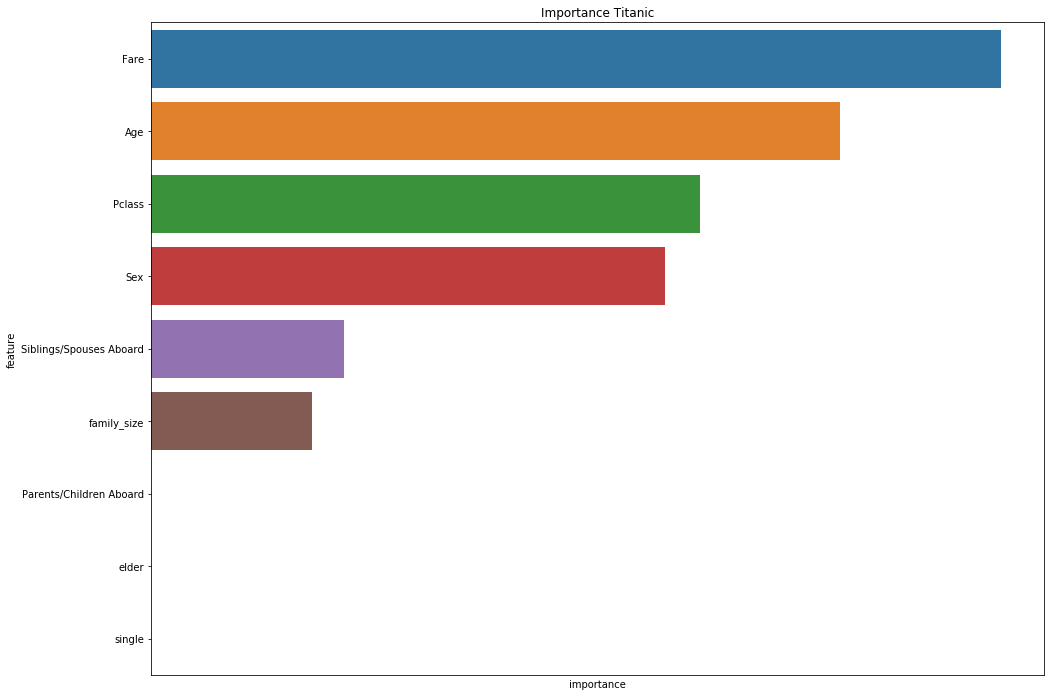

In [37]:
plot_feature_importance(feature_importance, title = 'Importance Titanic')

**Exercise:** Try tuning, adding, removing params.
    
See https://lightgbm.readthedocs.io/en/latest/Parameters.html

In [41]:
params = {
          'n_estimators': 500,  # Number of trees
          'num_leaves': 60,  # max number of leaves in tree
          'min_data_in_leaf': 2,
          'max_depth': -1,
          'learning_rate': 0.001,
          "boosting": "gbdt",
          "bagging_freq": 10,
          'num_threads': 8,
          "bagging_fraction": 0.7,
          "bagging_seed": 11,
          "metric": 'binary_logloss',
          "tree_learner": "feature", 
         }

In [42]:
y_pred_train, y_pred_test, feature_importance = train_lgb(X_train, X_test, y_train, y_test, params=params)

[1]	training's auc: 0.951956	training's binary_logloss: 0.596067	valid_1's auc: 0.754077	valid_1's binary_logloss: 0.63453
Training until validation scores don't improve for 50 rounds
[2]	training's auc: 0.956223	training's binary_logloss: 0.541783	valid_1's auc: 0.753555	valid_1's binary_logloss: 0.599741
[3]	training's auc: 0.954013	training's binary_logloss: 0.4971	valid_1's auc: 0.757534	valid_1's binary_logloss: 0.575045
[4]	training's auc: 0.95972	training's binary_logloss: 0.45761	valid_1's auc: 0.807371	valid_1's binary_logloss: 0.550108
[5]	training's auc: 0.969774	training's binary_logloss: 0.425194	valid_1's auc: 0.815786	valid_1's binary_logloss: 0.534921
[6]	training's auc: 0.976293	training's binary_logloss: 0.396283	valid_1's auc: 0.810502	valid_1's binary_logloss: 0.523254
[7]	training's auc: 0.97775	training's binary_logloss: 0.370492	valid_1's auc: 0.817613	valid_1's binary_logloss: 0.51125
[8]	training's auc: 0.979115	training's binary_logloss: 0.348144	valid_1's auc

0.9421720733427362
0.7752808988764045


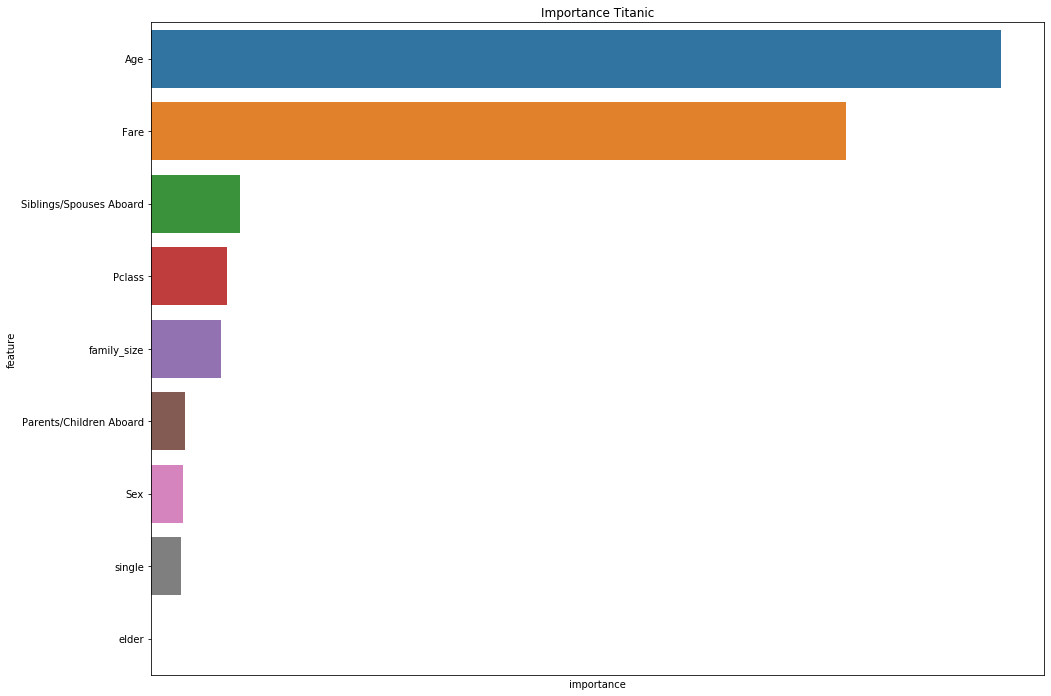

In [44]:
print(calc_accuracy(y_pred_train, y_train))
print(calc_accuracy(y_pred_test, y_test))
plot_feature_importance(feature_importance, title = 'Importance Titanic')

**Exercise:** Try creating new features, or removing unimportant features

In [83]:
df.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'Siblings/Spouses Aboard',
       'Parents/Children Aboard', 'Fare', 'family_size', 'single', 'elder'],
      dtype='object')

In [98]:
y = df.Survived
X = df.copy()
X["child"] = (X["Age"] < 18) * 1.0
X = X.drop(columns=["Age", "Fare", "Survived"])

In [94]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = pd.DataFrame(scaler.transform(X), columns=X.columns)

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

In [86]:
params = {
          'n_estimators': 5000,  # Number of trees
          'num_leaves': 6,  # max number of leaves in tree
          'min_data_in_leaf': 2,
          'max_depth': -1,
          'learning_rate': 0.001,
          "boosting": "gbdt",
          "bagging_freq": 10,
          'num_threads': 8,
          "bagging_fraction": 0.7,
          "bagging_seed": 11,
          "metric": 'binary_logloss',
          "tree_learner": "feature", 
         }

In [87]:
def train_lgb(X_train, X_valid, y_train, y_valid, params=None):

    model = lgb.LGBMClassifier(**params)
    model.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric=['auc', 'binary_logloss'],
            verbose=1, early_stopping_rounds=50)

    y_pred_train = model.predict(X_train)
    y_pred_valid = model.predict(X_valid)

    importance = pd.DataFrame()
    importance["feature"] = X.columns
    importance["importance"] = model.feature_importances_
    return y_pred_train, y_pred_valid, importance

In [102]:
X_train

,Pclass,Sex,Siblings/Spouses Aboard,Parents/Children Aboard,family_size,single,elder,child
605,2,2,1,2,3,0.0,0.0,0.0
768,2,2,0,0,0,1.0,0.0,0.0
29,3,1,0,0,0,1.0,0.0,0.0
49,3,1,4,1,5,0.0,0.0,1.0
105,3,2,0,0,0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...
218,2,1,0,0,0,1.0,0.0,0.0
223,1,1,1,0,1,0.0,0.0,0.0
271,1,1,0,1,1,0.0,0.0,0.0
474,3,1,1,0,1,0.0,0.0,0.0


In [103]:
y_pred_train, y_pred_test, feature_importance = train_lgb(X_train, X_test, y_train, y_test, params=params)

[1]	training's auc: 0.847009	training's binary_logloss: 0.663331	valid_1's auc: 0.792433	valid_1's binary_logloss: 0.678501
Training until validation scores don't improve for 50 rounds
[2]	training's auc: 0.847009	training's binary_logloss: 0.66289	valid_1's auc: 0.792433	valid_1's binary_logloss: 0.678121
[3]	training's auc: 0.847009	training's binary_logloss: 0.66245	valid_1's auc: 0.792433	valid_1's binary_logloss: 0.677741
[4]	training's auc: 0.847009	training's binary_logloss: 0.662011	valid_1's auc: 0.792433	valid_1's binary_logloss: 0.677363
[5]	training's auc: 0.847009	training's binary_logloss: 0.661573	valid_1's auc: 0.792433	valid_1's binary_logloss: 0.676985
[6]	training's auc: 0.847009	training's binary_logloss: 0.661136	valid_1's auc: 0.792433	valid_1's binary_logloss: 0.676609
[7]	training's auc: 0.847009	training's binary_logloss: 0.6607	valid_1's auc: 0.792433	valid_1's binary_logloss: 0.676233
[8]	training's auc: 0.847009	training's binary_logloss: 0.660265	valid_1's 

[73]	training's auc: 0.864878	training's binary_logloss: 0.63354	valid_1's auc: 0.830267	valid_1's binary_logloss: 0.652572
[74]	training's auc: 0.864878	training's binary_logloss: 0.633158	valid_1's auc: 0.830267	valid_1's binary_logloss: 0.652247
[75]	training's auc: 0.864878	training's binary_logloss: 0.632777	valid_1's auc: 0.830267	valid_1's binary_logloss: 0.651922
[76]	training's auc: 0.864878	training's binary_logloss: 0.632397	valid_1's auc: 0.830267	valid_1's binary_logloss: 0.651598
[77]	training's auc: 0.864878	training's binary_logloss: 0.632018	valid_1's auc: 0.830267	valid_1's binary_logloss: 0.651275
[78]	training's auc: 0.864878	training's binary_logloss: 0.63164	valid_1's auc: 0.830267	valid_1's binary_logloss: 0.650952
[79]	training's auc: 0.866137	training's binary_logloss: 0.631262	valid_1's auc: 0.827136	valid_1's binary_logloss: 0.65063
[80]	training's auc: 0.866137	training's binary_logloss: 0.630885	valid_1's auc: 0.827136	valid_1's binary_logloss: 0.650309
[81

0.6205923836389281
0.5898876404494382


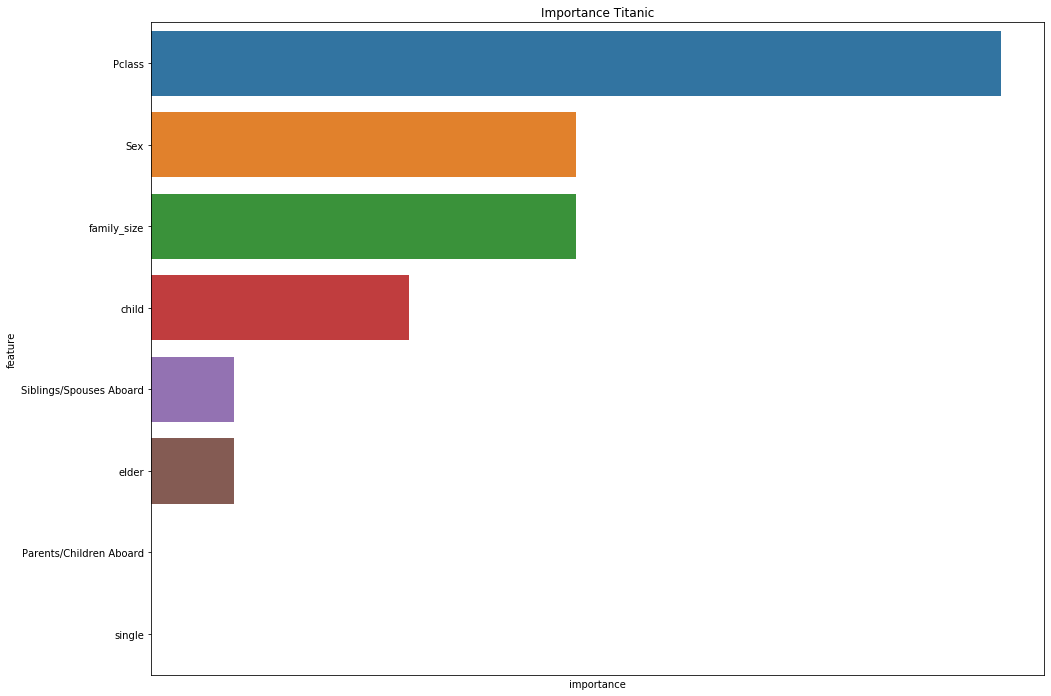

In [104]:
print(calc_accuracy(y_pred_train, y_train))
print(calc_accuracy(y_pred_test, y_test))
plot_feature_importance(feature_importance, title = 'Importance Titanic')

**Exercise**: Find how to save and load models

In [105]:
def train_lgb(X_train, X_valid, y_train, y_valid, params=None):

    model = lgb.LGBMClassifier(**params)
    model.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric=['auc', 'binary_logloss'],
            verbose=1, early_stopping_rounds=50)
    # Saving model
    model.booster_.save_model('model.txt')

    y_pred_train = model.predict(X_train)
    y_pred_valid = model.predict(X_valid)

    importance = pd.DataFrame()
    importance["feature"] = X.columns
    importance["importance"] = model.feature_importances_
    return y_pred_train, y_pred_valid, importance

In [107]:
# Loading model
bst = lgb.Booster(model_file='model.txt')